<a href="https://colab.research.google.com/github/kraphtdinner/Stock-Prediction/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn import preprocessing

In [17]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 1, 11)

df = web.DataReader("MSFT", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-07,103.269997,100.980003,101.639999,102.059998,35656100.0,100.915146
2019-01-08,103.970001,101.709999,103.040001,102.800003,31514400.0,101.646843
2019-01-09,104.879997,103.239998,103.860001,104.269997,32280800.0,103.100357
2019-01-10,103.750000,102.379997,103.220001,103.599998,30067600.0,102.437866
2019-01-11,103.440002,101.639999,103.190002,102.800003,28314200.0,101.646843


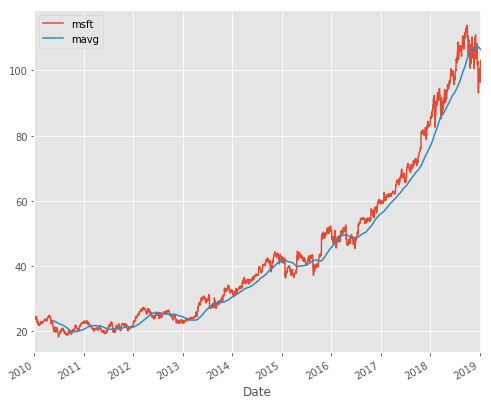

In [19]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='msft')
mavg.plot(label='mavg')
plt.legend()

In [26]:
# Generating two new features HL PCT and PCT change
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-01-07,100.915146,35656100.0,2.243772,0.413221
2019-01-08,101.646843,31514400.0,2.198446,-0.232917
2019-01-09,103.100357,32280800.0,1.572839,0.394758
2019-01-10,102.437866,30067600.0,1.322396,0.368143
2019-01-11,101.646843,28314200.0,1.750976,-0.377943


In [0]:
#Pre-processing the data

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [0]:
X_train = X
y_train = y

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

In [42]:
#Checking confidence

X_test = X_lately
y_test = y[-forecast_out:]

confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print (confidencereg)
print (confidencepoly2)
print (confidencepoly3)
print (confidenceknn)

0.7717967686453987
0.877926722107295
0.5801259117406454
-0.46849213076030044


In [46]:
#checking forecast

forecast_set = clfpoly2.predict(X_lately)
dfreg['Forecast'] = np.nan

print (forecast_set)

[106.55783577 107.91996745 108.57342669 108.65917798 105.72159032
 102.36660191 101.97344022 102.48118654 100.80495137  95.02652301
  95.79459379 102.9911956  100.90337181 100.62723151 100.99555062
 100.44905321  97.98878712 100.87581339 101.33945903 102.55951117
 103.41726612 102.9087099  102.69961662]


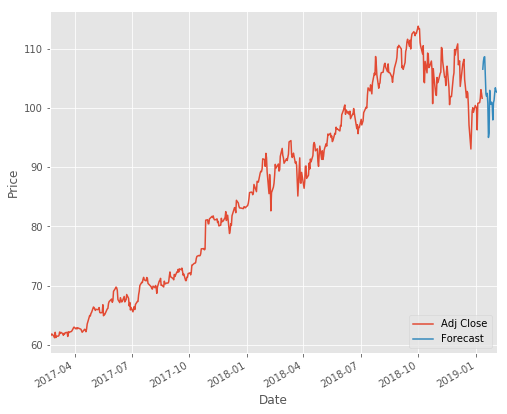

In [47]:
#plotting the forecast

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()